# German Credit Data

This notebook analyses the London Property Listing dataset

- https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk

### Steps:
- Step 1: Load Data
- Step 2: First 5 rows
- Step 3: Plot Data
- Step 4: Prepare for Modelling
- Step 5: XGBoost

# Step 0: Imports

In [121]:
#============================================
# Imports
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.2f}'.format

# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost
from xgboost import XGBClassifier

# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Gini by split
def gini_group(y_true=None, y_score=None, group=None, round=2):
    """
    Calculate Gini for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_score=y_score[group==this_level]
        values.append(roc_auc_score(y_true=this_y_true, y_score=this_y_score)*2-1)
    return pd.DataFrame({'group':levels, 'Gini':values}).round(round)
#============================================

# Step 1: Load Data

In [93]:
#============================================
# Load Data
df=pd.read_csv('german_credit_data.csv')
df.columns = df.columns.str.replace(' ', '_')

# Rename featues
rename_dct = {
    'laufkont' : 'status',
    'laufzeit' : 'duration',
    'moral' : 'credit_history',
    'verw' : 'purpose',
    'hoehe' : 'amount',
    'sparkont' : 'savings',
    'beszeit' : 'employment_duration',
    'rate' : 'installment_rate',
    'famges' : 'personal_status_sex',
    'buerge' : 'other_debtors',
    'wohnzeit' : 'present_residence',
    'verm' : 'property',
    'alter' : 'age',
    'weitkred' : 'other_installment_plans',
    'wohn' : 'housing',
    'bishkred' : 'number_credits',
    'beruf' : 'job',
    'pers' : 'people_liable',
    'telef' : 'telephone',
    'gastarb' : 'foreign_worker',
    'kredit' : 'credit_risk'
}
df = df.rename(columns=rename_dct)

# Mapp features
map_status={
1 : 'no_checking_account',
2 : '(-inf, 0)',
3 : '(0, 200)',
4 : '(200, inf)'}

map_credit_history={
0 : 'past delays',
1 : 'critical account',
2 : 'no credits',
3 : 'paid until now',
4 : 'paid this bank'}

map_purpose={
0 : 'others',
1 : 'car(new)',
2 : 'car(used)',
3 : 'furniture_equipment',
4 : 'radio_television',
5 : 'domestic appliances',
6 : 'repairs',
7 : 'education',
8 : 'vacation',
9 : 'retraining',
10 : 'business'}

map_savings={
1 : 'unknown/no_account',
2 : '(-inf,100)',
3 : '(100,500)',
4 : '(500,1000)',
5 : '(1000,inf)'}

map_employment_duration={
1 : 'unemp',
2 : '(0,1)',
3 : '(1,4)',
4 : '(4,7)',
5 : '(7,inf)'}

map_installment_rate={
1 : '(35,inf)',
2 : '(25,35)',
3 : '(20,25)',
4 : '(-inf,20)'}

map_personal_status_sex={
1 : 'male_divorcedseparated',
2 : 'femalenonsingle_or_malesingle',
3 : 'male_marriedwidowed',
4 : 'female_single'}

map_other_debtors={
1 : 'none',
2 : 'coapplicant',
3 : 'guarantor'}

map_present_residence={
1 : '(0,1)',
2 : '(1,4)',
3 : '(4,7)',
4 : '(7,inf)'}

map_property={
1 : 'unk_noproperty',
2 : 'car_or_other',
3 : 'savings_lifeins',
4 : 'realestate'}

map_other_installment_plans={
1 : 'bank',
2 : 'stores',
3 : 'none'}

map_housing={
1 : 'forfree',
2 : 'rent',
3 : 'own'}

map_number_credits={
1 : '(0,1)',
2 : '(2,3)',
3 : '(4,5)',
4 : '(6,inf)'}

map_job={
1 : 'unemp_unskill_nonres',
2 : 'unskilled_resident',
3 : 'skilledemp_official',
4 : 'high_quual_emp'}

map_people_liable={
1 : '(3,inf)',
2 : '(0,2)'}

map_telephone={
1 : 'no',
2 : 'yes'}

map_foreign_worker={
1 : 'yes',
2 : 'no'}

df['status']                  = df['status'].map(map_status)
df['credit_history']          = df['credit_history'].map(map_credit_history)
df['purpose']                 = df['purpose'].map(map_purpose)
df['savings']                 = df['savings'].map(map_savings)
df['employment_duration']     = df['employment_duration'].map(map_employment_duration)
df['installment_rate']        = df['installment_rate'].map(map_installment_rate)
df['personal_status_sex']     = df['personal_status_sex'].map(map_personal_status_sex)
df['other_debtors']           = df['other_debtors'].map(map_other_debtors)
df['present_residence']       = df['present_residence'].map(map_present_residence)
df['property']                = df['property'].map(map_property)
df['other_installment_plans'] = df['other_installment_plans'].map(map_other_installment_plans)
df['housing']                 = df['housing'].map(map_housing)
df['number_credits']          = df['number_credits'].map(map_number_credits)
df['job']                     = df['job'].map(map_job)
df['people_liable']           = df['people_liable'].map(map_people_liable)
df['telephone']               = df['telephone'].map(map_telephone)
df['foreign_worker']          = df['foreign_worker'].map(map_foreign_worker)

# Bad Flag
df['bad_flag'] = 1-df['credit_risk']
df.drop(columns=['credit_risk'], inplace=True)

print('--------------------')
print('## Information ##')
df.info()
print('--------------------')
print('')
#============================================

--------------------
## Information ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   employment_duration      1000 non-null   object
 7   installment_rate         1000 non-null   object
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   object
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  ho

# Step 2: First 5 rows

In [94]:
#============================================
# First 5 rows
print('--------------------')
print('## First 5 rows ##')
print(df.head(5))
print('--------------------')
#============================================

--------------------
## First 5 rows ##
                status  duration  credit_history     purpose  amount  \
0  no_checking_account        18  paid this bank   car(used)    1049   
1  no_checking_account         9  paid this bank      others    2799   
2            (-inf, 0)        12      no credits  retraining     841   
3  no_checking_account        12  paid this bank      others    2122   
4  no_checking_account        12  paid this bank      others    2171   

              savings employment_duration installment_rate  \
0  unknown/no_account               (0,1)        (-inf,20)   
1  unknown/no_account               (1,4)          (25,35)   
2          (-inf,100)               (4,7)          (25,35)   
3  unknown/no_account               (1,4)          (20,25)   
4  unknown/no_account               (1,4)        (-inf,20)   

             personal_status_sex other_debtors present_residence  \
0  femalenonsingle_or_malesingle          none           (7,inf)   
1            male_

# Step 3: Plot Data

### Response ['bad_flag']

There are 1000 examples, 700 goods and 300 bads.

### Numerical Features 

['duration', 'amount', 'age']

### Categorical Featues 

['status', 'credit_history', 'purpose', 'savings', 
       'employment_duration',
       'installment_rate', 'personal_status_sex', 'other_debtors',
       'present_residence', 'property', 'other_installment_plans', 'housing',
       'number_credits', 'job', 'people_liable', 'telephone',
       'foreign_worker']

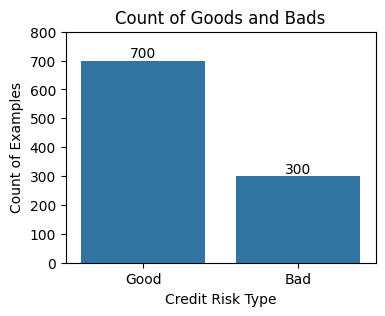

In [95]:
#============================================
# Plot Response

# Summarise for the plot
df_smry=df['bad_flag'].value_counts().reset_index()
df_smry['bad_flag']=df_smry['bad_flag'].map({0:'Good', 1:'Bad'})

# Response plot
plt.figure(figsize=(4,3))
ax=sns.barplot(df_smry, x='bad_flag', y='count')
ax.bar_label(ax.containers[0])
ax.set_xlabel('Credit Risk Type')
ax.set_ylabel('Count of Examples')
plt.ylim(0, 800) 
plt.title('Count of Goods and Bads')
plt.show()
#============================================

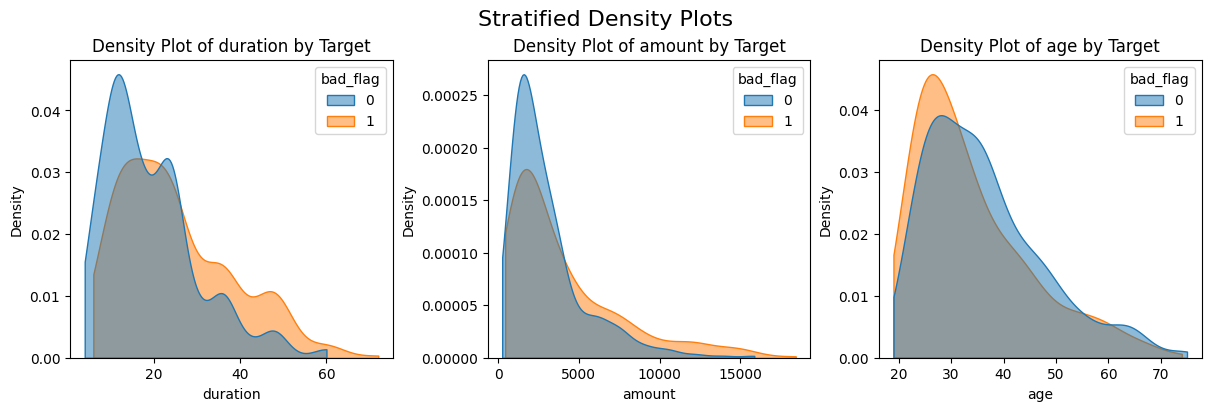

In [96]:
#============================================
# Plot Numeric Features

# Numeric Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('bad_flag')
num_numeric_cols=len(numeric_cols)

# KDE Plots
fig, axes = plt.subplots(1, num_numeric_cols, figsize=(12, 4), constrained_layout=True)
for i, this_var in enumerate(numeric_cols):
    sns.kdeplot(data=df, 
                x=this_var, 
                hue='bad_flag', 
                fill=True, 
                common_norm=False,
                cut=0,
                alpha=0.5,
                ax=axes[i])
    axes[i].set_title(f'Density Plot of {this_var} by Target', fontsize=12)
fig.suptitle('Stratified Density Plots', fontsize=16)
plt.show()
#============================================

# Insights from Stratified KDE Plots

The stratified KDE (Kernel Density Estimate) plots provide insights into the distribution of numerical features(`duration`, `amount`, `age`) stratified by the target variable (`bad_flag`). Here are the key observations:

## 1. Duration
- The distribution of `duration` for both good and bad credit risks shows that longer durations are more common among bad credit risks.
- There is a noticeable peak for bad credit risks at higher durations, indicating that longer loan durations might be associated with higher credit risk.

## 2. Amount
- The distribution of `amount` for both good and bad credit risks shows that higher loan amounts are more common among bad credit risks.
- There is a noticeable peak for bad credit risks at higher loan amounts, suggesting that larger loan amounts might be associated with higher credit risk.

## 3. Age
- The distribution of `age` for both good and bad credit risks shows that younger individuals are more common among bad credit risks.
- There is a noticeable peak for bad credit risks at lower ages, indicating that younger age might be associated with higher credit risk.

---

Overall, the stratified KDE plots suggest that longer loan durations, higher loan amounts, and younger ages are associated with higher credit risk. These insights can be useful for understanding the characteristics of high-risk loans and individuals.


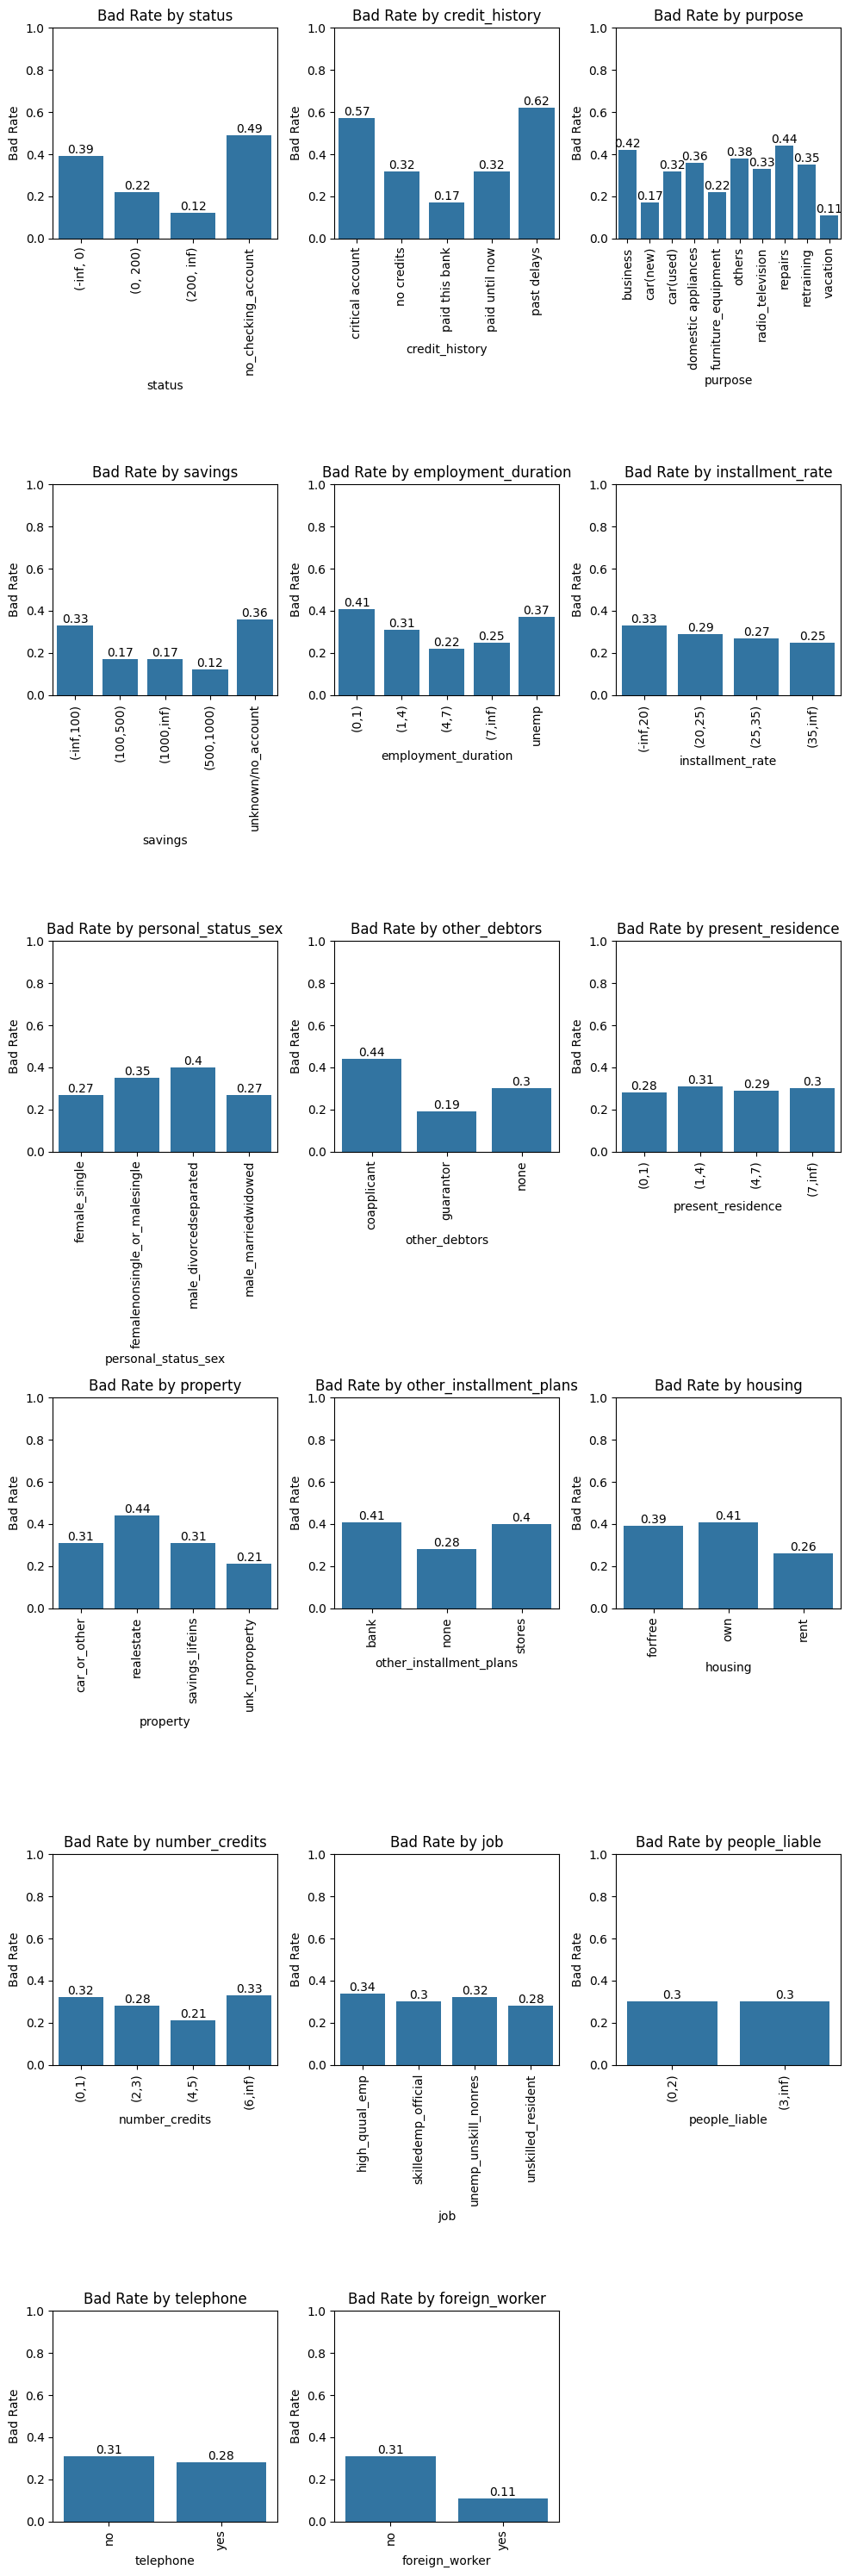

In [97]:
#============================================
# Plot Categorical Features

# Identify categorical columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns
num_categorical_cols = len(categorical_cols)

# Set up grid dimensions
cols = 3
rows = (num_categorical_cols + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over categorical columns
for i, col in enumerate(categorical_cols):
    df_smry = df[['bad_flag', col]].groupby(col).mean().reset_index().round(2)

    ax = axes[i]  # Get the current axis
    sns.barplot(data=df_smry, x=col, y='bad_flag', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_xlabel(col)
    ax.set_ylabel('Bad Rate')
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, 1)
    ax.set_title(f'Bad Rate by {col}')


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
#============================================

# Step 4: Prepare for Modelling

Undertake the following:

- one-hot dummy encoding of categorical featuers
- train-test split

In [98]:
# One-Hot Encoding
df2=copy.deepcopy(pd.get_dummies(df,dtype=int))
df2.columns=df2.columns.str.replace('-', '_').str.replace(' ', '_')

# X and y
X=df2.drop(['bad_flag'], axis=1)
y=df2['bad_flag']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: XGBoost

In [181]:
# Fit the XGBoost Model
model_xgb = XGBClassifier(
    max_depth=6, 
    min_child_weight=20,
    n_estimators=10000, 
    learning_rate=0.0001, 
    subsample=1, 
    colsample_bytree=0.1,
    seed=7)

#model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

# Predicted and Actual bad_flag
pred_train_xgb=pd.DataFrame({'Split': 'Train', 'bad_flag': y_train, 'pred_xgb': model_xgb.predict_proba(X_train)[:,1].round(6)})
pred_test_xgb=pd.DataFrame({'Split': 'Test',   'bad_flag': y_test,  'pred_xgb': model_xgb.predict_proba(X_test)[:,1].round(6)})
pred=pd.concat([pred_train_xgb, pred_test_xgb],axis=0).reset_index(drop=True)

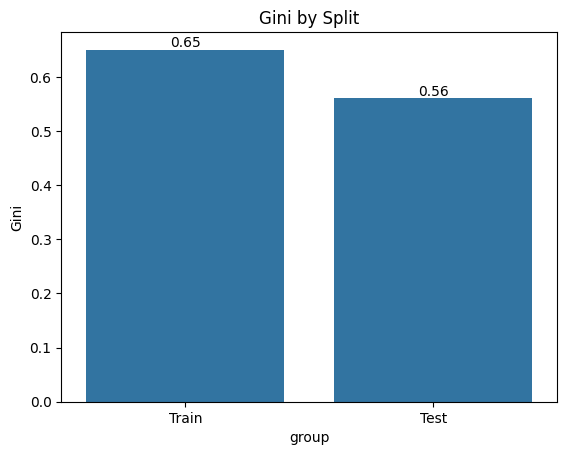

In [182]:
# Gini
df_rsq=gini_group(y_true=pred['bad_flag'], y_score=pred['pred_xgb'], group=pred['Split'])

ax=sns.barplot(data=df_rsq, x='group', y='Gini')
ax.bar_label(ax.containers[0])
plt.title('Gini by Split')
plt.show()